In [1]:
#load
import pandas as pd
df=pd.read_csv("/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
print(df)

         Destination Port   Flow Duration   Total Fwd Packets  \
0                      22         1266342                  41   
1                      22         1319353                  41   
2                      22             160                   1   
3                      22         1303488                  41   
4                   35396              77                   1   
...                   ...             ...                 ...   
286462                443          196135                  49   
286463                443          378424                  49   
286464                443          161800                  70   
286465                443          142864                  50   
286466                443          186928                  46   

         Total Backward Packets  Total Length of Fwd Packets  \
0                            44                         2664   
1                            44                         2664   
2                          

 Label
PortScan    158930
BENIGN      127537
Name: count, dtype: int64


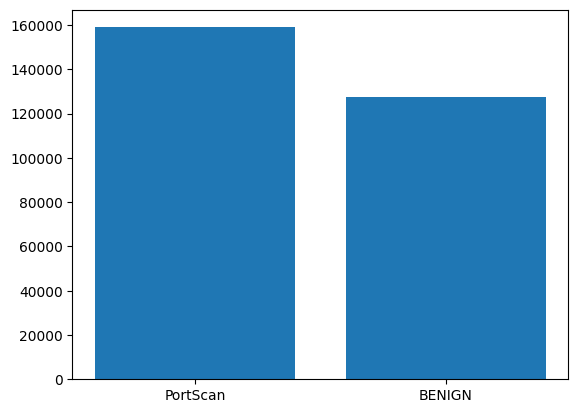

In [2]:
#visaulize
import pandas as pd
import matplotlib.pyplot as plt
data=df[' Label']
counts = data.value_counts()
plt.bar(counts.index, counts.values)
print(counts)

In [3]:
#dropnas
df.dropna()
print(df)
#remove space because dumb dumbs
df.columns = df.columns.str.strip()
columns = df.columns
print(columns)

         Destination Port   Flow Duration   Total Fwd Packets  \
0                      22         1266342                  41   
1                      22         1319353                  41   
2                      22             160                   1   
3                      22         1303488                  41   
4                   35396              77                   1   
...                   ...             ...                 ...   
286462                443          196135                  49   
286463                443          378424                  49   
286464                443          161800                  70   
286465                443          142864                  50   
286466                443          186928                  46   

         Total Backward Packets  Total Length of Fwd Packets  \
0                            44                         2664   
1                            44                         2664   
2                          

In [4]:
import pandas as pd
from scipy import stats

statistically_sig = []

for col in df.columns:
    if col == "Label":
        continue  # Skip the label column itself
    
    benign = df[df["Label"] == "BENIGN"][col]
    ddos = df[df["Label"] == "PortScan"][col]
    
    # Handle numerical columns (int/float)
    if pd.api.types.is_numeric_dtype(df[col]):

        # Check normality (Shapiro-Wilk) and variance (Levene)
        _, p_benign = stats.shapiro(benign)
        _, p_ddos = stats.shapiro(ddos)
        _, p_levene = stats.levene(benign, ddos)
        
        # Decide test: t-test if normal & equal variance, else Mann-Whitney U
        if p_benign > 0.05 and p_ddos > 0.05 and p_levene > 0.05:
            _, p_value = stats.ttest_ind(benign, ddos)
            test_used = "t-test"
        else:
            _, p_value = stats.mannwhitneyu(benign, ddos)
            test_used = "Mann-Whitney U"
    
    # Handle categorical columns (strings/objects)
    else:
        # Create contingency table
        contingency_table = pd.crosstab(df[col], df["Label"])
        
        # Skip if any expected frequency is too low for Chi-square
        if (contingency_table.values < 5).any():
            continue
        
        # Chi-square test
        _, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_used = "Chi-square"
    
    # Ensure p_value is float (sometimes Chi-square returns array)
    p_value = float(p_value) if hasattr(p_value, '__iter__') else p_value
    
    if p_value < 0.05:
        statistically_sig.append(col)

# Print results
print("Statistically significant features (p < 0.05):")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 127537.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 158930.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3048: RuntimeWarning: invalid value encountered in subtract
  numer = (Ntot - k) * np.sum(Ni * (Zbari - Zbar)**2, axis=0)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3053: RuntimeWarning: invalid value encountered in subtract
  dvar += np.sum((Zij[i] - Zbari[i])**2, axis=0)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/p

Statistically significant features (p < 0.05):


In [5]:
print(len(statistically_sig))
print(statistically_sig)

67
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segmen

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

best_feat = []
df2 = df.copy()

# Binary label: 1 if DDoS, 0 otherwise
y_true = (df2['Label'] == "PortScan").astype(int)

for col in statistically_sig:
    # Encode non-numeric features
    if not np.issubdtype(df2[col].dtype, np.number):
        df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))
    
    # Ensure column is numeric and clean
    df2[col] = pd.to_numeric(df2[col], errors='coerce')
    df2[col].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN or inf and align y_true
    mask = df2[col].notna()
    if mask.sum() == 0:
        continue  # Skip if all values are invalid
    try:
        auc = roc_auc_score(y_true[mask], df2[col][mask])
        if auc > 0.60:
            best_feat.append(col)
    except ValueError as e:
        print(f"Skipping {col}: {e}")


/tmp/ipykernel_13/1814531017.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_13/1814531017.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [7]:
print(len(best_feat))
print(best_feat)

10
['Destination Port', 'Flow Packets/s', 'Flow IAT Min', 'Fwd Packets/s', 'Bwd Packets/s', 'PSH Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']


In [8]:
#drop even more useless bois
best_feat.append("Label")


df3=df[best_feat]

print(df3)

        Destination Port  Flow Packets/s  Flow IAT Min  Fwd Packets/s  \
0                     22       67.122468             0      32.376720   
1                     22       64.425518             1      31.075838   
2                     22    12500.000000           160    6250.000000   
3                     22       63.675308             0      31.454068   
4                  35396    38961.038960            28   12987.012990   
...                  ...             ...           ...            ...   
286462               443      540.444082             1     249.827925   
286463               443      285.394161             0     129.484388   
286464               443     1069.221261             1     432.632880   
286465               443      783.962370             1     349.983201   
286466               443      551.014294            -1     246.084054   

        Bwd Packets/s  PSH Flag Count  Down/Up Ratio  Init_Win_bytes_forward  \
0           34.745748               1      

/tmp/ipykernel_13/1842346671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Label'] = df3['Label'].map({'BENIGN': 0, 'PortScan': 1})


Label
1    158930
0    127537
Name: count, dtype: int64


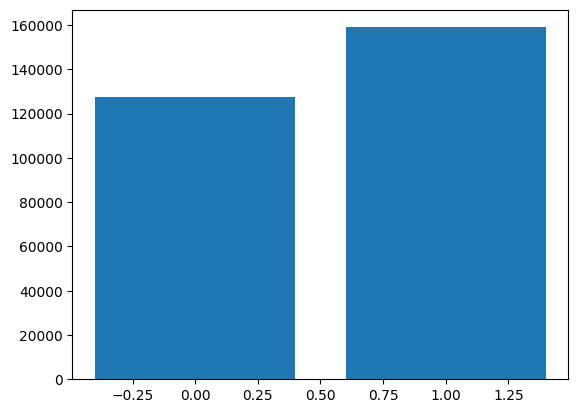

In [9]:
#convert bengin to 0 and ddos to 1
df3['Label'] = df3['Label'].map({'BENIGN': 0, 'PortScan': 1})
#visaulize
import pandas as pd
import matplotlib.pyplot as plt
data=df3['Label']
counts = data.value_counts()
plt.bar(counts.index, counts.values)
print(counts)

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# First, replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Then drop rows with any NaN values (which were previously inf/-inf)
df.dropna(inplace=True)

# Now proceed with your scaling
for col in best_feat:
    if col == "Label":
        print("opsie")
        continue
    scaler = MinMaxScaler()
    df[[col]] = scaler.fit_transform(df[[col]])

df3 = df[best_feat]
print(df3)

opsie
        Destination Port  Flow Packets/s  Flow IAT Min  Fwd Packets/s  \
0               0.000336        0.400013  1.325178e-07       0.000011   
1               0.000336        0.400013  1.427115e-07       0.000010   
2               0.000336        0.402500  1.763506e-06       0.002083   
3               0.000336        0.400013  1.325178e-07       0.000010   
4               0.541314        0.407792  4.179408e-07       0.004329   
...                  ...             ...           ...            ...   
286462          0.006775        0.400108  1.427115e-07       0.000083   
286463          0.006775        0.400057  1.325178e-07       0.000043   
286464          0.006775        0.400214  1.427115e-07       0.000144   
286465          0.006775        0.400157  1.427115e-07       0.000117   
286466          0.006775        0.400110  1.223241e-07       0.000082   

        Bwd Packets/s  PSH Flag Count  Down/Up Ratio  Init_Win_bytes_forward  \
0            0.000017             1.0

Class weights: {'PortScan': 0.4449265104248588, 'BENIGN': 0.555073489575141}
Fold 1 Accuracy: 99.85%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     20367
    PortScan       1.00      1.00      1.00     25409

    accuracy                           1.00     45776
   macro avg       1.00      1.00      1.00     45776
weighted avg       1.00      1.00      1.00     45776

Fold 2 Accuracy: 99.85%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     20366
    PortScan       1.00      1.00      1.00     25409

    accuracy                           1.00     45775
   macro avg       1.00      1.00      1.00     45775
weighted avg       1.00      1.00      1.00     45775

Fold 3 Accuracy: 99.87%
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     20366
    PortScan       1.00      1.00      1.00     25409

    accuracy                     

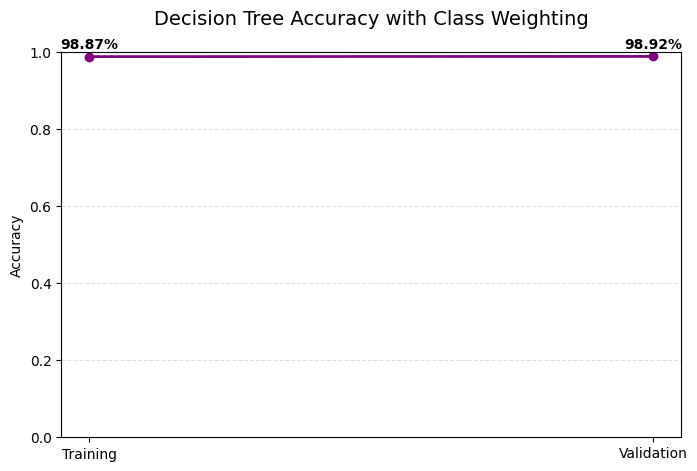

<Figure size 800x600 with 0 Axes>

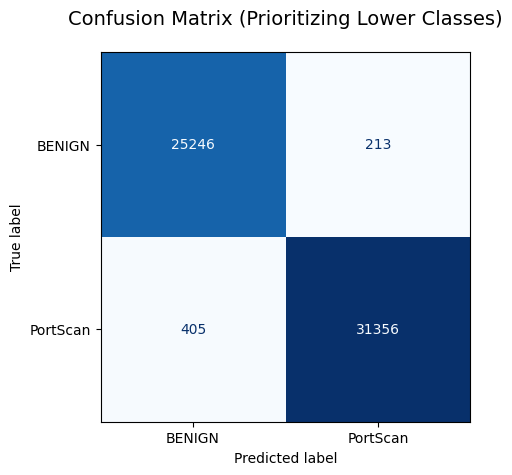


Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.98      0.99      0.99     25459
    PortScan       0.99      0.99      0.99     31761

    accuracy                           0.99     57220
   macro avg       0.99      0.99      0.99     57220
weighted avg       0.99      0.99      0.99     57220



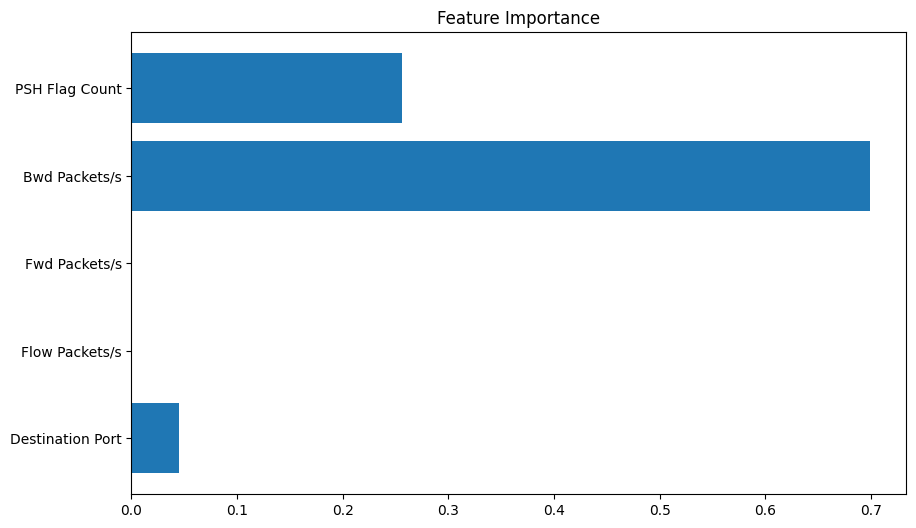

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
X = df3.drop(["Label","Init_Win_bytes_backward","Init_Win_bytes_forward","Down/Up Ratio","Flow IAT Min","min_seg_size_forward"], axis=1)
y = df3["Label"]

# Split data into train and test WITH stratification (keeping 20% for final validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Calculate class weights to prioritize lower classes
class_counts = y_train.value_counts()
class_weights = {cls: 1/(count/len(y_train)) for cls, count in class_counts.items()}
# Normalize weights so they sum to 1
sum_weights = sum(class_weights.values())
class_weights = {k: v/sum_weights for k, v in class_weights.items()}

print("Class weights:", class_weights)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy scores
fold_accuracies = []

# Perform stratified k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Train Decision Tree with class weights
    model = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=20,
        random_state=42,
        class_weight='balanced' # using our calculated weights
    )
    
    model.fit(X_fold_train, y_fold_train)
    
    # Get predictions
    fold_pred = model.predict(X_fold_test)
    
    # Evaluate
    fold_acc = accuracy_score(y_fold_test, fold_pred)
    fold_accuracies.append(fold_acc)
    
    print(f"Fold {fold + 1} Accuracy: {fold_acc:.2%}")
    print(classification_report(y_fold_test, fold_pred))

# Calculate average accuracy across folds
avg_fold_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {avg_fold_accuracy:.2%}")

# Now train on full training data with the same parameters
final_model = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=20,
    random_state=42,
    class_weight=class_weights
)
final_model.fit(X_train, y_train)

# Get predictions on validation set
val_pred = final_model.predict(X_val)

# Evaluate
train_acc = accuracy_score(y_train, final_model.predict(X_train))
val_acc = accuracy_score(y_val, val_pred)

print(f"\nFinal Model Training Accuracy: {train_acc:.2%}")
print(f"Final Model Validation Accuracy: {val_acc:.2%}")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(['Training', 'Validation'], [train_acc, val_acc], 
         marker='o',
         linestyle='-',
         linewidth=2,
         color='purple')

# Add labels
for i, acc in enumerate([train_acc, val_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontweight='bold')

plt.title('Decision Tree Accuracy with Class Weighting', fontsize=14, pad=20)
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    val_pred,
    cmap='Blues',
    display_labels=final_model.classes_,
    colorbar=False
)
plt.title('Confusion Matrix (Prioritizing Lower Classes)', fontsize=14, pad=20)
plt.grid(False)
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, val_pred))

# Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, final_model.feature_importances_)
plt.title('Feature Importance')
plt.show()